In [1]:
import aprofiles as apro
import numpy as np
import matplotlib.pyplot as plt

path = "data/e-profile/2021/09/09/L2_0-20000-001492_A20210909.nc"
apro_reader = apro.reader.ReadProfiles(path)
profiles = apro_reader.read()

profiles.range_correction(inplace=True)
profiles.gaussian_filter(sigma=0.2, inplace=True)

/home/augustinm/anaconda3/lib/python3.7/site-packages/xarray/core/merge.py:10: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


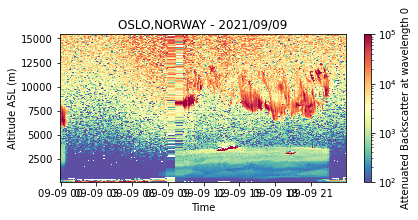

In [22]:
profiles.quickplot(vmin=1e2, vmax=1e5, log=True, cmap='Spectral_r')

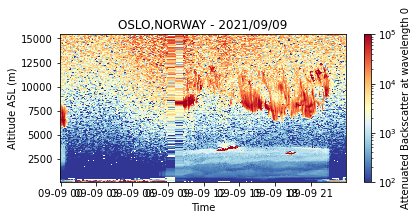

In [10]:
profiles.quickplot(vmin=1e2, vmax=1e5, log=True)

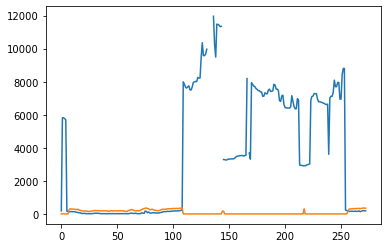

In [33]:
#condensation: use first layer of cloud_base_height
plt.plot(profiles.data.cloud_base_height.data[:,0])
plt.plot(profiles.data.vertical_visibility.data)

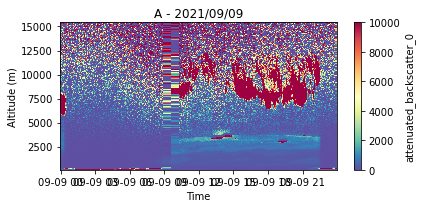

In [9]:
profiles.quickplot()

In [3]:
profiles.data.attenuated_backscatter_0.long_name

'Attenuated Backscatter at wavelength 0'